# Train an XGBoost model with retail sales forecasting with hyperparameter search

Now that we finished processing the data, we are now ready to train a model to forecast future sales. We will leverage the worker pods to run multiple training jobs in parallel, speeding up the hyperparameter search.

## Import modules and define constants

In [1]:
import cudf
import gcsfs
import xgboost as xgb
import pandas as pd
import numpy as np
import optuna
import gc
import time
import pickle 
import copy
import json

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib

from dask.distributed import wait
from dask_kubernetes.operator import KubeCluster
from dask.distributed import Client

In [2]:
# Choose the same RAPIDS image you used for launching the notebook session
rapids_image = "rapidsai/rapidsai-core-nightly:23.08-cuda11.8-runtime-ubuntu22.04-py3.10"
# Use the number of worker nodes in your Kubernetes cluster.
n_workers = 3
# Bucket that contains the processed data pickles, refer to start_here.ipynb
bucket_name = "<Put the name of the bucket here>"

# List of stores and product departments
STORES = ["CA_1", "CA_2", "CA_3", "CA_4", "TX_1", "TX_2", "TX_3", "WI_1", "WI_2", "WI_3"]
DEPTS = ["HOBBIES_1", "HOBBIES_2", "HOUSEHOLD_1", "HOUSEHOLD_2", "FOODS_1", "FOODS_2", "FOODS_3"]

## Define cross-validation folds

[**Cross-validation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) is a statistical method for estimating how well a machine learning model generalizes to an independent data set. The method is also useful for evaluating the choice of a given combination of model hyperparameters.

To estimate the capacity to generalize, we define multiple cross-validation **folds** consisting of mulitple pairs of `(training set, validation set)`. For each fold, we fit a model using the training set and evaluate its accuracy on the validation set. The  "goodness" score for a given hyperparameter combination is the accuracy of the model on each validation set, averaged over all cross-validation folds.

Great care must be taken when defining cross-validation folds for time-series data. We are not allowed to use the future to predict the past, so the training set must precede (in time) the validation set. Consequently, we partition the data set in the time dimension and assign the training and validation sets using time ranges:

In [4]:
# Cross-validation folds and held-out test set (in time dimension)
# The held-out test set is used for final evaluation
cv_folds = [  # (train_set, validation_set)
    ([0, 1114], [1114, 1314]),
    ([0, 1314], [1314, 1514]),
    ([0, 1514], [1514, 1714]),
    ([0, 1714], [1714, 1914])
]
n_folds = len(cv_folds)
holdout = [1914, 1942]
time_horizon = 1942

It is helpful to visualize the cross-validation folds using Matplotlib.

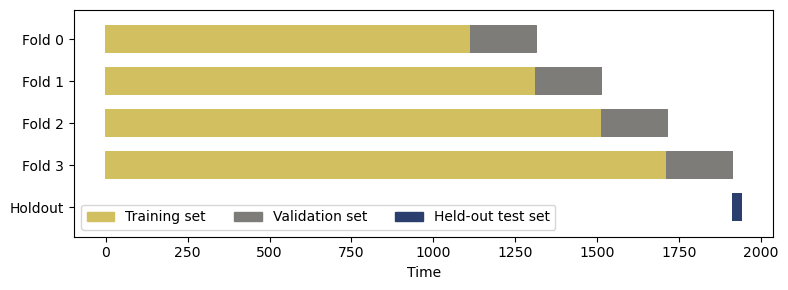

In [5]:
cv_cmap = matplotlib.colormaps["cividis"]
plt.figure(figsize=(8, 3))

for i, (train_mask, valid_mask) in enumerate(cv_folds):
    idx = np.array([np.nan] * time_horizon)
    idx[np.arange(*train_mask)] = 1
    idx[np.arange(*valid_mask)] = 0
    plt.scatter(
        range(time_horizon),
        [i + 0.5] * time_horizon,
        c=idx,
        marker="_",
        capstyle="butt",
        s=1,
        lw=20,
        cmap=cv_cmap,
        vmin=-1.5,
        vmax=1.5
    )

idx = np.array([np.nan] * time_horizon)
idx[np.arange(*holdout)] = -1
plt.scatter(
    range(time_horizon),
    [n_folds + 0.5] * time_horizon,
    c=idx,
    marker="_",
    capstyle="butt",
    s=1,
    lw=20,
    cmap=cv_cmap,
    vmin=-1.5,
    vmax=1.5
)

plt.xlabel("Time")
plt.yticks(
    ticks=np.arange(n_folds + 1) + 0.5,
    labels=[f"Fold {i}" for i in range(n_folds)] + ["Holdout"]
)
plt.ylim([len(cv_folds) + 1.2, -0.2])

norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=1.5)
plt.legend(
    [Patch(color=cv_cmap(norm(1))),
     Patch(color=cv_cmap(norm(0))),
     Patch(color=cv_cmap(norm(-1)))],
    ["Training set", "Validation set", "Held-out test set"],
    ncol=3,
    loc="best"
)
plt.tight_layout()

## Launch a Dask client on Kubernetes

Let us set up a Dask cluster using the `KubeCluster` class.

In [8]:
cluster = KubeCluster(name="rapids-dask",
                      image=rapids_image,
                      worker_command="dask-cuda-worker",
                      n_workers=n_workers,
                      resources={"limits": {"nvidia.com/gpu": "1"}},
                      env={"DISABLE_JUPYTER": "true", "EXTRA_PIP_PACKAGES": "optuna gcsfs"})

Output()

In [9]:
cluster

KubeCluster(rapids-dask, 'tcp://rapids-dask-scheduler.kubeflow-user-example-com:8786', workers=1, threads=1, memory=117.93 GiB)

In [10]:
client = Client(cluster)

In [11]:
client

<Client: 'tcp://10.36.3.19:8786' processes=3 threads=3, memory=353.79 GiB>

## Define the custom evaluation metric

The M5 forecasting competition defines a custom metric called WRMSSE as follows:
$$
WRMSSE = \sum w_i \cdot RMSSE_i
$$
i.e. WRMSEE is a weighted sum of RMSSE for all product items $i$. RMSSE is in turn defined to be
$$
RMSSE = \sqrt{\frac{1/h \cdot \sum_t{\left(Y_t - \hat{Y}_t\right)}^2}{1/(n-1)\sum_t{(Y_t - Y_{t-1})}^2}}
$$
where the squared error of the prediction (forecast) is normalized by the speed at which the sales amount changes per unit in the training data.

Here is the implementation of the WRMSSE using cuDF. We use the product weights $w_i$ as computed in the first preprocessing notebook.

In [12]:
def wrmsse(product_weights, df, pred_sales, train_mask, valid_mask):
    """Compute WRMSSE metric"""
    df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
    df_valid = df[(df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])]

    # Compute denominator: 1/(n-1) * sum( (y(t) - y(t-1))**2 )
    diff = df_train.sort_values(["item_id", "day_id"]).groupby(["item_id"])[["sales"]].diff(1)
    x = df_train[["item_id", "day_id"]].join(diff, how="left").rename(columns={"sales": "diff"}).sort_values(["item_id", "day_id"])
    x["diff"] = x["diff"] ** 2
    xx = x.groupby(["item_id"])[["diff"]].agg(["sum", "count"]).sort_index()
    xx.columns = xx.columns.map("_".join)
    xx["denominator"] = xx["diff_sum"] / xx["diff_count"]
    t = xx.reset_index()
    
    # Compute numerator: 1/h * sum( (y(t) - y_pred(t))**2 )
    X_valid = df_valid.drop(columns=["item_id", "cat_id", "day_id", "sales"])
    if "dept_id" in X_valid.columns:
        X_valid = X_valid.drop(columns=["dept_id"])
    df_pred = cudf.DataFrame({
        "item_id": df_valid["item_id"].copy(),
        "pred_sales": pred_sales,
        "sales": df_valid["sales"].copy()
    })
    df_pred["diff"] = (df_pred["sales"] - df_pred["pred_sales"])**2
    yy = df_pred.groupby(["item_id"])[["diff"]].agg(["sum", "count"]).sort_index()
    yy.columns = yy.columns.map("_".join)
    yy["numerator"] = yy["diff_sum"] / yy["diff_count"]
    
    zz = yy[["numerator"]].join(xx[["denominator"]], how="left")
    zz = zz.join(product_weights, how="left").sort_index()
    # Filter out zero denominator.
    # This can occur if the product was never on sale during the period in the training set
    zz = zz[zz["denominator"] != 0]
    zz["rmsse"] = np.sqrt(zz["numerator"] / zz["denominator"])
    t = zz["rmsse"].multiply(zz["weights"])
    return zz["rmsse"].multiply(zz["weights"]).sum()

## Define the training and hyperparameter search pipeline using Optuna

Optuna lets us define the training procedure iteratively, i.e. as if we were to write an ordinary function to train a single model. Instead of a fixed hyperparameter combination, the function now takes in a `trial` object which yields different hyperparameter combinations.

In this example, we partition the training data according to the store and then fit a separate XGBoost model per data segment.

In [13]:
def objective(trial):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 6, step=1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1, 2),
    }
    scores = [[] for store in STORES]
    
    for store_id, store in enumerate(STORES):
        print(f"Processing store {store}...")
        with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
            df = cudf.DataFrame(pd.read_pickle(f))
        for train_mask, valid_mask in cv_folds:
            df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
            df_valid = df[(df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])]

            X_train, y_train = df_train.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"]), df_train["sales"]
            X_valid = df_valid.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"])

            clf = xgb.XGBRegressor(**params)
            clf.fit(X_train, y_train)
            pred_sales = clf.predict(X_valid)
            scores[store_id].append(wrmsse(product_weights, df, pred_sales, train_mask, valid_mask))
            del df_train, df_valid, X_train, y_train, clf
            gc.collect()
        del df
        gc.collect()
    
    # We can sum WRMSSE scores over data segments because data segments contain disjoint sets of time series
    return np.array(scores).sum(axis=0).mean()

Using the Dask cluster client, we execute multiple training jobs in parallel. Optuna keeps track of the progress in the hyperparameter search using in-memory Dask storage.

In [14]:
##### Number of hyperparameter combinations to try in parallel
n_trials = 9  # Using a small n_trials so that the demo can finish quickly
#n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.RandomSampler(seed=0),
                            storage=dask_storage)
futures = []
for i in range(0, n_trials, n_workers):
    iter_range = (i, min([i + n_workers, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ]
        }
    )

tstart = time.perf_counter()
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])
    for fut in partition["futures"]:
        _ = fut.result()  # Ensure that the training job was successful
    tnow = time.perf_counter()
    print(f"Best cross-validation metric: {study.best_value}, Time elapsed = {tnow - tstart}")
tend = time.perf_counter()
print(f"Total time elapsed = {tend - tstart}")

/tmp/ipykernel_3102/456600745.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..3
Best cross-validation metric: 9.689218658589553, Time elapsed = 491.4758385729983
Testing hyperparameter combinations 3..6
Best cross-validation metric: 9.689218658589553, Time elapsed = 1047.8801612580028
Testing hyperparameter combinations 6..9
Best cross-validation metric: 9.689218658589553, Time elapsed = 1650.7563961980013
Total time elapsed = 1650.7610972189977


Once the hyperparameter search is complete, we fetch the optimal hyperparameter combination using the attributes of the `study` object.

In [15]:
study.best_params

{'lambda': 0.003077053443211648,
 'alpha': 0.14187101103672142,
 'colsample_bytree': 0.682210700857315,
 'max_depth': 4,
 'min_child_weight': 0.00017240426024865184,
 'gamma': 0.0014694435419424668,
 'tweedie_variance_power': 1.4375872112626924}

In [16]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[9.689218658589553], datetime_start=datetime.datetime(2023, 7, 27, 1, 39, 4, 604443), datetime_complete=datetime.datetime(2023, 7, 27, 1, 47, 9, 804887), params={'lambda': 0.003077053443211648, 'alpha': 0.14187101103672142, 'colsample_bytree': 0.682210700857315, 'max_depth': 4, 'min_child_weight': 0.00017240426024865184, 'gamma': 0.0014694435419424668, 'tweedie_variance_power': 1.4375872112626924}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lambda': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'alpha': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'colsample_bytree': FloatDistribution(high=1.0, log=False, low=0.2, step=None), 'max_depth': IntDistribution(high=6, log=False, low=2, step=1), 'min_child_weight': FloatDistribution(high=100.0, log=True, low=1e-08, step=None), 'gamma': FloatDistribution(high=1.0, log=True, low=1e-08, step=None), 'tweedie_variance_power': Flo

In [17]:
# Make a deep copy to preserve the dictionary after deleting the Dask cluster
best_params = copy.deepcopy(study.best_params)
best_params

{'lambda': 0.003077053443211648,
 'alpha': 0.14187101103672142,
 'colsample_bytree': 0.682210700857315,
 'max_depth': 4,
 'min_child_weight': 0.00017240426024865184,
 'gamma': 0.0014694435419424668,
 'tweedie_variance_power': 1.4375872112626924}

In [18]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params.json", "w") as f:
    json.dump(best_params, f)

## Train the final XGBoost model and evaluate

Using the optimal hyperparameters found in the search, fit a new model using the whole training data. As in the previous section, we fit a separate XGBoost model per data segment.

In [19]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params.json", "r") as f:
    best_params = json.load(f)
with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
    product_weights = cudf.DataFrame(pd.read_pickle(f))

In [20]:
def final_train(best_params):
    fs = gcsfs.GCSFileSystem()
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
    }
    params.update(best_params)
    model = {}
    train_mask = [0, 1914]

    for store in STORES:
        print(f"Processing store {store}...")
        with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
            df = cudf.DataFrame(pd.read_pickle(f))

        df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
        X_train, y_train = df_train.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"]), df_train["sales"]

        clf = xgb.XGBRegressor(**params)
        clf.fit(X_train, y_train)
        model[store] = clf
    del df
    gc.collect()
    
    return model

In [21]:
model = final_train(best_params)

Processing store CA_1...
Processing store CA_2...
Processing store CA_3...
Processing store CA_4...
Processing store TX_1...
Processing store TX_2...
Processing store TX_3...
Processing store WI_1...
Processing store WI_2...
Processing store WI_3...


Let's now evaluate the final model using the held-out test set:

In [23]:
test_wrmsse = 0
for store in STORES:
    with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
        df = cudf.DataFrame(pd.read_pickle(f))
    df_test = df[(df["day_id"] >= holdout[0]) & (df["day_id"] < holdout[1])]
    X_test = df_test.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"])
    pred_sales = model[store].predict(X_test)
    test_wrmsse += wrmsse(product_weights, df, pred_sales, train_mask=[0, 1914], valid_mask=holdout)
print(f"WRMSSE metric on the held-out test set: {test_wrmsse}")

WRMSSE metric on the held-out test set: 10.495262182826213


In [24]:
# Save the model to the Cloud Storage
with fs.open(f"{bucket_name}/final_model.pkl", "wb") as f:
    pickle.dump(model, f)

## Create an ensemble model using a different strategy for segmenting sales data

It is common to create an **ensemble model** where multiple machine learning methods are used to obtain better predictive performance. Prediction is made from an ensemble model by averaging the prediction output of the constituent models.

In this example, we will create a second model by segmenting the sales data in a different way. Instead of splitting by stores, we will split the data by both stores and product categories.

In [25]:
def objective_alt(trial):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
        "lambda": trial.suggest_float("lambda", 1e-8, 100.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 100.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "max_depth": trial.suggest_int("max_depth", 2, 6, step=1),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-8, 100, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1, 2),
    }
    scores = [[] for i in range(len(STORES) * len(DEPTS))]
    
    for store_id, store in enumerate(STORES):
        for dept_id, dept in enumerate(DEPTS):
            print(f"Processing store {store}, department {dept}...")
            with fs.open(f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb") as f:
                df = cudf.DataFrame(pd.read_pickle(f))
            for train_mask, valid_mask in cv_folds:
                df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
                df_valid = df[(df["day_id"] >= valid_mask[0]) & (df["day_id"] < valid_mask[1])]

                X_train, y_train = df_train.drop(columns=["item_id", "cat_id", "day_id", "sales"]), df_train["sales"]
                X_valid = df_valid.drop(columns=["item_id", "cat_id", "day_id", "sales"])

                clf = xgb.XGBRegressor(**params)
                clf.fit(X_train, y_train)
                sales_pred = clf.predict(X_valid)
                scores[store_id * len(DEPTS) + dept_id].append(wrmsse(product_weights, df, sales_pred, train_mask, valid_mask))
                del df_train, df_valid, X_train, y_train, clf
                gc.collect()
            del df
            gc.collect()
    
    # We can sum WRMSSE scores over data segments because data segments contain disjoint sets of time series
    return np.array(scores).sum(axis=0).mean()

In [26]:
##### Number of hyperparameter combinations to try in parallel
n_trials = 9  # Using a small n_trials so that the demo can finish quickly
#n_trials = 100

# Optimize in parallel on your Dask cluster
backend_storage = optuna.storages.InMemoryStorage()
dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)
study = optuna.create_study(direction="minimize",
                            sampler=optuna.samplers.RandomSampler(seed=0),
                            storage=dask_storage)
futures = []
for i in range(0, n_trials, n_workers):
    iter_range = (i, min([i + n_workers, n_trials]))
    futures.append(
        {
            "range": iter_range,
            "futures": [
                client.submit(study.optimize, objective_alt, n_trials=1, pure=False)
                for _ in range(*iter_range)
            ]
        }
    )

tstart = time.perf_counter()
for partition in futures:
    iter_range = partition["range"]
    print(f"Testing hyperparameter combinations {iter_range[0]}..{iter_range[1]}")
    _ = wait(partition["futures"])
    for fut in partition["futures"]:
        _ = fut.result()  # Ensure that the training job was successful
    tnow = time.perf_counter()
    print(f"Best cross-validation metric: {study.best_value}, Time elapsed = {tnow - tstart}")
tend = time.perf_counter()
print(f"Total time elapsed = {tend - tstart}")

/tmp/ipykernel_3102/383703293.py:7: ExperimentalWarning: DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.
  dask_storage = optuna.integration.DaskStorage(storage=backend_storage, client=client)


Testing hyperparameter combinations 0..3
Best cross-validation metric: 9.657402162051978, Time elapsed = 663.513354638002
Testing hyperparameter combinations 3..6
Best cross-validation metric: 9.657402162051978, Time elapsed = 1379.8620550880005
Testing hyperparameter combinations 6..9
Best cross-validation metric: 9.657402162051978, Time elapsed = 2183.6284268570016
Total time elapsed = 2183.632464492999


In [27]:
# Make a deep copy to preserve the dictionary after deleting the Dask cluster
best_params_alt = copy.deepcopy(study.best_params)
best_params_alt

{'lambda': 0.003077053443211648,
 'alpha': 0.14187101103672142,
 'colsample_bytree': 0.682210700857315,
 'max_depth': 4,
 'min_child_weight': 0.00017240426024865184,
 'gamma': 0.0014694435419424668,
 'tweedie_variance_power': 1.4375872112626924}

In [28]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params_alt.json", "w") as f:
    json.dump(best_params_alt, f)

Using the optimal hyperparameters found in the search, fit a new model using the whole training data.

In [33]:
def final_train_alt(best_params):
    fs = gcsfs.GCSFileSystem()
    with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
        product_weights = cudf.DataFrame(pd.read_pickle(f))
    params = {
        "n_estimators": 100,
        "verbosity": 0,
        "learning_rate": 0.01,
        "objective": "reg:tweedie",
        "tree_method": "gpu_hist",
        "grow_policy": "depthwise",
        "predictor": "gpu_predictor",
        "enable_categorical": True,
    }
    params.update(best_params)
    model = {}
    train_mask = [0, 1914]
    
    for store_id, store in enumerate(STORES):
        for dept_id, dept in enumerate(DEPTS):
            print(f"Processing store {store}, department {dept}...")
            with fs.open(f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb") as f:
                df = cudf.DataFrame(pd.read_pickle(f))
            for train_mask, valid_mask in cv_folds:
                df_train = df[(df["day_id"] >= train_mask[0]) & (df["day_id"] < train_mask[1])]
                X_train, y_train = df_train.drop(columns=["item_id", "cat_id", "day_id", "sales"]), df_train["sales"]

                clf = xgb.XGBRegressor(**params)
                clf.fit(X_train, y_train)
                model[(store, dept)] = clf
            del df
            gc.collect()
    
    return model

In [34]:
fs = gcsfs.GCSFileSystem()
with fs.open(f"{bucket_name}/params_alt.json", "r") as f:
    best_params_alt = json.load(f)
with fs.open(f"{bucket_name}/product_weights.pkl", "rb") as f:
    product_weights = cudf.DataFrame(pd.read_pickle(f))

In [35]:
model_alt = final_train_alt(best_params_alt)

Processing store CA_1, department HOBBIES_1...
Processing store CA_1, department HOBBIES_2...
Processing store CA_1, department HOUSEHOLD_1...
Processing store CA_1, department HOUSEHOLD_2...
Processing store CA_1, department FOODS_1...
Processing store CA_1, department FOODS_2...
Processing store CA_1, department FOODS_3...
Processing store CA_2, department HOBBIES_1...
Processing store CA_2, department HOBBIES_2...
Processing store CA_2, department HOUSEHOLD_1...
Processing store CA_2, department HOUSEHOLD_2...
Processing store CA_2, department FOODS_1...
Processing store CA_2, department FOODS_2...
Processing store CA_2, department FOODS_3...
Processing store CA_3, department HOBBIES_1...
Processing store CA_3, department HOBBIES_2...
Processing store CA_3, department HOUSEHOLD_1...
Processing store CA_3, department HOUSEHOLD_2...
Processing store CA_3, department FOODS_1...
Processing store CA_3, department FOODS_2...
Processing store CA_3, department FOODS_3...
Processing store CA

In [57]:
# Save the model to the Cloud Storage
with fs.open(f"{bucket_name}/final_model_alt.pkl", "wb") as f:
    pickle.dump(model_alt, f)

Now consider an ensemble consisting of the two models `model` and `model_alt`. We evaluate the ensemble by computing the WRMSSE metric for the average of the predictions of the two models.

In [58]:
test_wrmsse = 0
for store in STORES:
    print(f"Processing store {store}...")
    # Prediction from Model 1
    with fs.open(f"{bucket_name}/combined_df_store_{store}.pkl", "rb") as f:
        df = cudf.DataFrame(pd.read_pickle(f))
    df_test = df[(df["day_id"] >= holdout[0]) & (df["day_id"] < holdout[1])]
    X_test = df_test.drop(columns=["item_id", "dept_id", "cat_id", "day_id", "sales"])
    df_test["pred1"] = model[store].predict(X_test)
    
    # Prediction from Model 2
    df_test["pred2"] = [np.nan] * len(df_test)
    df_test["pred2"] = df_test["pred2"].astype("float32")
    for dept in DEPTS:
        with fs.open(f"{bucket_name}/combined_df_store_{store}_dept_{dept}.pkl", "rb") as f:
            df2 = cudf.DataFrame(pd.read_pickle(f))
        df2_test = df2[(df2["day_id"] >= holdout[0]) & (df2["day_id"] < holdout[1])]
        X_test = df2_test.drop(columns=["item_id", "cat_id", "day_id", "sales"])
        assert np.sum(df_test["dept_id"] == dept) == len(X_test)
        df_test["pred2"][df_test["dept_id"] == dept] = model_alt[(store, dept)].predict(X_test)
    
    # Average prediction
    df_test["avg_pred"] = (df_test["pred1"] + df_test["pred2"]) / 2.0

    test_wrmsse += wrmsse(product_weights, df, df_test["avg_pred"],
                          train_mask=[0, 1914], valid_mask=holdout)
print(f"WRMSSE metric on the held-out test set: {test_wrmsse}")

Processing store CA_1...
Processing store CA_2...
Processing store CA_3...
Processing store CA_4...
Processing store TX_1...
Processing store TX_2...
Processing store TX_3...
Processing store WI_1...
Processing store WI_2...
Processing store WI_3...
WRMSSE metric on the held-out test set: 11.055364531163706


In [ ]:
# Close the Dask cluster to clean up
cluster.close()